In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
from aps_ai.beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

89970


In [5]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'

In [6]:
os.mkdir(temp_work_dir)

In [8]:
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [9]:
os.chdir(temp_work_dir)

In [10]:
input_beam_path = "primary_optics_system_beam.dat"

In [11]:
move_motors = ['vkb_4']

In [12]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [13]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

0.00014351675448181058


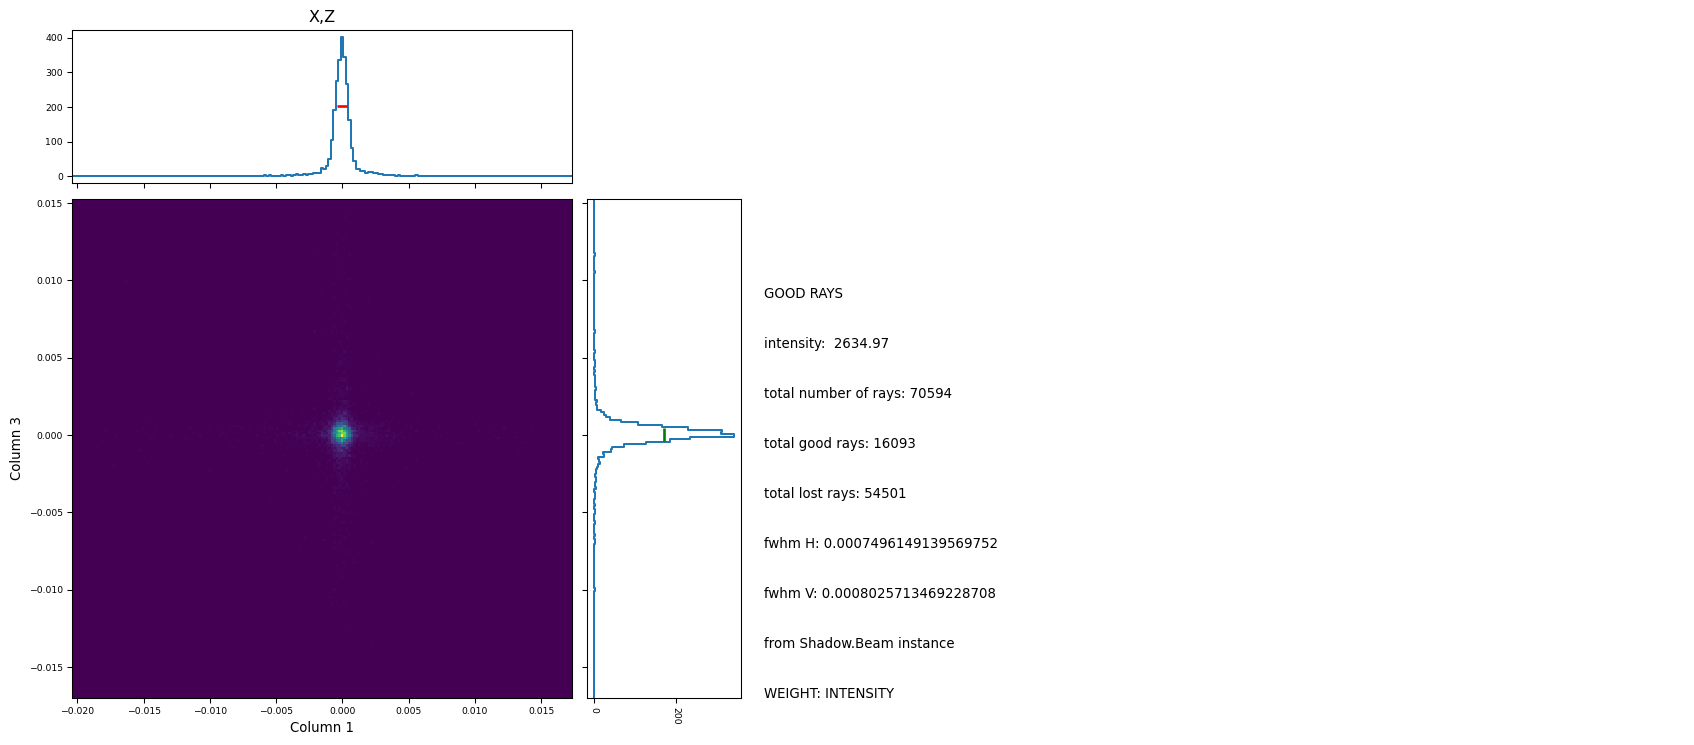

In [14]:
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system=focusing_system, 
                                                                random_seed=DEFAULT_RANDOM_SEED)
print(centroid)
_ = plot_shadow_beam_spatial_distribution(out_beam)

In [15]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[0.]


In [16]:
initial_centroids = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_centroids = []
final_out_beams = []

min_trans = -0.14
max_trans = 0.14

for outer in tqdm(range(10)):
    translations = np.random.uniform(min_trans, max_trans, size=1)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                          motor_types=move_motors, 
                                          initial_motor_positions=test_absolute_movements, 
                                          random_seed=DEFAULT_RANDOM_SEED)
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, guess_min=min_trans, guess_max=max_trans)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')

  0%|          | 0/10 [00:00<?, ?it/s]

Initial motor positions are [-0.10731754]
motors ['vkb_4'] trans [0.] current loss 0.10681624403704196
Initial loss is 0.10681624403704196
motors ['vkb_4'] trans [0.11787442] current loss 0.010741989177680485
motors ['vkb_4'] trans [0.12376815] current loss 0.016663628618677213
motors ['vkb_4'] trans [0.1119807] current loss 0.004799326412850258
motors ['vkb_4'] trans [0.10019326] current loss 0.007099550039332535
motors ['vkb_4'] trans [0.10608698] current loss 0.0011551107567036455
motors ['vkb_4'] trans [0.09429954] current loss 0.013052383706682798
motors ['vkb_4'] trans [0.10019326] current loss 0.007099550039332576
motors ['vkb_4'] trans [0.10756041] current loss 0.0003574608767237553
motors ['vkb_4'] trans [0.10903384] current loss 0.0018317333639948545
motors ['vkb_4'] trans [0.10719205] current loss 0.00011547317728857516
motors ['vkb_4'] trans [0.1068237] current loss 0.0004193023635710279
motors ['vkb_4'] trans [0.10728414] current loss 0.00012412930103426417


 10%|█         | 1/10 [00:47<07:08, 47.64s/it]

Test 0 success True
Initial motor positions are [0.05044666]
motors ['vkb_4'] trans [0.] current loss 0.050342020559358006
Initial loss is 0.050342020559358006
motors ['vkb_4'] trans [-0.10392358] current loss 0.053149286896609464
motors ['vkb_4'] trans [-0.10911976] current loss 0.058326218798768724
motors ['vkb_4'] trans [-0.0987274] current loss 0.04797015482744013
motors ['vkb_4'] trans [-0.08833504] current loss 0.0376370861908228
motors ['vkb_4'] trans [-0.0727465] current loss 0.022170273913824274
motors ['vkb_4'] trans [-0.04156943] current loss 0.009051343667988869
motors ['vkb_4'] trans [0.00519618] current loss 0.05550965358935967
motors ['vkb_4'] trans [-0.05326083] current loss 0.00275312498487994
motors ['vkb_4'] trans [-0.06495224] current loss 0.014557392732335635
motors ['vkb_4'] trans [-0.05033798] current loss 0.00023182001461120974
motors ['vkb_4'] trans [-0.04741513] current loss 0.0031533766974017295
motors ['vkb_4'] trans [-0.0510687] current loss 0.0005441355677

 20%|██        | 2/10 [01:47<07:19, 54.98s/it]

Test 1 success True
Initial motor positions are [-0.09020332]
motors ['vkb_4'] trans [0.] current loss 0.08975295134011389
Initial loss is 0.08975295134011389


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4'] trans [-0.0904892] current loss 0.18041307721128552


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4'] trans [-0.09501366] current loss 0.18564546965781492
motors ['vkb_4'] trans [-0.08596474] current loss 0.17551752869300577
motors ['vkb_4'] trans [-0.07691582] current loss 0.1668397893410648
motors ['vkb_4'] trans [-0.06334244] current loss 0.1530085271989764
motors ['vkb_4'] trans [-0.03619568] current loss 0.1259729510056774
motors ['vkb_4'] trans [0.00452446] current loss 0.08524248280683668
motors ['vkb_4'] trans [0.08596474] current loss 0.00419209342781283
motors ['vkb_4'] trans [0.20812516] current loss 0.11736226914064744
motors ['vkb_4'] trans [0.11650484] current loss 0.026233575674759792
motors ['vkb_4'] trans [0.05542463] current loss 0.0345529218956394
motors ['vkb_4'] trans [0.09359977] current loss 0.0035265366896776833
motors ['vkb_4'] trans [0.10123479] current loss 0.01121451489342824
motors ['vkb_4'] trans [0.09169101] current loss 0.0015966203844496646
motors ['vkb_4'] trans [0.08978225] current loss 0.00035132325214187396
motors ['vkb_4'] trans [0

 30%|███       | 3/10 [03:05<07:38, 65.48s/it]

Test 2 success True
Initial motor positions are [0.09899281]
motors ['vkb_4'] trans [0.] current loss 0.09863468047499248
Initial loss is 0.09863468047499248
motors ['vkb_4'] trans [0.12604377] current loss 10000.0
motors ['vkb_4'] trans [0.13234595] current loss 10000.0
motors ['vkb_4'] trans [0.11974158] current loss 10000.0
motors ['vkb_4'] trans [0.12761931] current loss 10000.0
motors ['vkb_4'] trans [0.12604377] current loss 10000.0
motors ['vkb_4'] trans [0.] current loss 0.09863468047499248
Initial loss is 0.09863468047499248
motors ['vkb_4'] trans [-0.09692262] current loss 0.002184254314952932
motors ['vkb_4'] trans [-0.10176875] current loss 0.002715603811769297
motors ['vkb_4'] trans [-0.09207648] current loss 0.007072000711741594
motors ['vkb_4'] trans [-0.09813415] current loss 0.0009677914460999758
motors ['vkb_4'] trans [-0.09934568] current loss 0.00028896176320742165
motors ['vkb_4'] trans [-0.10176875] current loss 0.002715603811769321
motors ['vkb_4'] trans [-0.1005

 40%|████      | 4/10 [03:50<05:44, 57.47s/it]

Test 3 success True
Initial motor positions are [0.11501911]
motors ['vkb_4'] trans [0.] current loss 0.1143797354230559
Initial loss is 0.1143797354230559
motors ['vkb_4'] trans [-0.11293721] current loss 0.002195412820917757
motors ['vkb_4'] trans [-0.11858407] current loss 0.0035123759983437287
motors ['vkb_4'] trans [-0.10729035] current loss 0.007892446481966789
motors ['vkb_4'] trans [-0.11434892] current loss 0.0007745936185424101
motors ['vkb_4'] trans [-0.11576064] current loss 0.0006636327187600643
motors ['vkb_4'] trans [-0.11858407] current loss 0.0035123759983437803
motors ['vkb_4'] trans [-0.11717235] current loss 0.002083191810025688
motors ['vkb_4'] trans [-0.11540771] current loss 0.00032133394753737656
motors ['vkb_4'] trans [-0.11505478] current loss 0.0001232886766933105
motors ['vkb_4'] trans [-0.11434892] current loss 0.0007745936185425844
motors ['vkb_4'] trans [-0.11470185] current loss 0.0004284163340675579
motors ['vkb_4'] trans [-0.11514301] current loss 0.00

 50%|█████     | 5/10 [04:38<04:29, 53.83s/it]

Test 4 success True
Initial motor positions are [0.07000551]
motors ['vkb_4'] trans [0.] current loss 0.06979994158027789
Initial loss is 0.06979994158027789
motors ['vkb_4'] trans [-0.12151001] current loss 0.05118230378726798
motors ['vkb_4'] trans [-0.12758551] current loss 0.05723720014520825
motors ['vkb_4'] trans [-0.11543451] current loss 0.045128970702738226
motors ['vkb_4'] trans [-0.10328351] current loss 0.03306335481364111
motors ['vkb_4'] trans [-0.085057] current loss 0.015109629146830597
motors ['vkb_4'] trans [-0.048604] current loss 0.0214369169171683
motors ['vkb_4'] trans [-0.0668305] current loss 0.003299390482822486
motors ['vkb_4'] trans [-0.0303775] current loss 0.039564608705030216
motors ['vkb_4'] trans [-0.048604] current loss 0.0214369169171683
motors ['vkb_4'] trans [-0.07138713] current loss 0.0013034128869293144
motors ['vkb_4'] trans [-0.07594375] current loss 0.0059083999288961735
motors ['vkb_4'] trans [-0.07024797] current loss 0.0001904701971950145
mo

 60%|██████    | 6/10 [05:38<03:43, 55.87s/it]

Test 5 success True
Initial motor positions are [0.0955204]
motors ['vkb_4'] trans [0.] current loss 0.09518220703789035
Initial loss is 0.09518220703789035
motors ['vkb_4'] trans [0.00491153] current loss 0.10006498369587562
motors ['vkb_4'] trans [0.0051571] current loss 0.10030853340803411
motors ['vkb_4'] trans [0.00466595] current loss 0.09982210854134921
motors ['vkb_4'] trans [0.0041748] current loss 0.09933301107014494
motors ['vkb_4'] trans [0.00343807] current loss 0.09860058290247382
motors ['vkb_4'] trans [0.00196461] current loss 0.09713494756939414
motors ['vkb_4'] trans [-0.00024558] current loss 0.09493788500182856
motors ['vkb_4'] trans [-0.00466595] current loss 0.09053847111078667
motors ['vkb_4'] trans [-0.01129651] current loss 0.08394126819953998
motors ['vkb_4'] trans [-0.02455764] current loss 0.07075310448116696
motors ['vkb_4'] trans [-0.04444933] current loss 0.05096329726654435
motors ['vkb_4'] trans [-0.0842327] current loss 0.01147633718037071
motors ['vkb

 70%|███████   | 7/10 [06:55<03:09, 63.04s/it]

Test 6 success True
Initial motor positions are [0.01432838]
motors ['vkb_4'] trans [0.] current loss 0.01453290347382791
Initial loss is 0.01453290347382791
motors ['vkb_4'] trans [-0.10934649] current loss 0.09455336274483214
motors ['vkb_4'] trans [-0.11481381] current loss 0.10000358980979214
motors ['vkb_4'] trans [-0.10387917] current loss 0.08910255253394818
motors ['vkb_4'] trans [-0.09294452] current loss 0.07820303204710954
motors ['vkb_4'] trans [-0.07654254] current loss 0.06185496036766804
motors ['vkb_4'] trans [-0.0437386] current loss 0.02922458320676189
motors ['vkb_4'] trans [0.00546732] current loss 0.02002901650982137
motors ['vkb_4'] trans [0.10387917] current loss 0.11756640838973047
motors ['vkb_4'] trans [0.05467324] current loss 0.06880064377488866
motors ['vkb_4'] trans [-0.00683416] current loss 0.007658365835225135
motors ['vkb_4'] trans [-0.01913564] current loss 0.004760268759234094
motors ['vkb_4'] trans [-0.0437386] current loss 0.029224583206761887
moto

 80%|████████  | 8/10 [08:20<02:19, 69.89s/it]

Test 7 success True
Initial motor positions are [0.00312366]
motors ['vkb_4'] trans [0.] current loss 0.003247441271328613
Initial loss is 0.003247441271328613
motors ['vkb_4'] trans [0.02366632] current loss 0.026723243337502398
motors ['vkb_4'] trans [0.02484963] current loss 0.027905829843756377
motors ['vkb_4'] trans [0.022483] current loss 0.025537841596631923
motors ['vkb_4'] trans [0.02011637] current loss 0.023171443887488423
motors ['vkb_4'] trans [0.01656642] current loss 0.019921449643261945
motors ['vkb_4'] trans [0.00946653] current loss 0.012781334238766607
motors ['vkb_4'] trans [-0.00118332] current loss 0.0020561901478019957
motors ['vkb_4'] trans [-0.022483] current loss 0.019400198075479623
motors ['vkb_4'] trans [-0.01183316] current loss 0.008703913457780738
motors ['vkb_4'] trans [-0.00384578] current loss 0.0006436780009875027
motors ['vkb_4'] trans [-0.00650824] current loss 0.003329343593515938
motors ['vkb_4'] trans [-0.00318016] current loss 0.000115187250357

 90%|█████████ | 9/10 [09:19<01:06, 66.64s/it]

Test 8 success True
Initial motor positions are [0.02084681]
motors ['vkb_4'] trans [0.] current loss 0.021030782832582324
Initial loss is 0.021030782832582324
motors ['vkb_4'] trans [-0.0310048] current loss 0.010172373374036084
motors ['vkb_4'] trans [-0.03255504] current loss 0.011739879205978892
motors ['vkb_4'] trans [-0.02945456] current loss 0.008603711773735447
motors ['vkb_4'] trans [-0.02635408] current loss 0.005465231190036263
motors ['vkb_4'] trans [-0.02170336] current loss 0.0007817792491903815
motors ['vkb_4'] trans [-0.01240192] current loss 0.008612841274179175
motors ['vkb_4'] trans [-0.01705264] current loss 0.003921325578896153
motors ['vkb_4'] trans [-0.02054068] current loss 0.0004175230947461684
motors ['vkb_4'] trans [-0.019378] current loss 0.0015774209419581993
motors ['vkb_4'] trans [-0.02083135] current loss 0.00015424547073924987
motors ['vkb_4'] trans [-0.02112202] current loss 0.00021745837734621527
motors ['vkb_4'] trans [-0.02090402] current loss 0.000

100%|██████████| 10/10 [10:07<00:00, 60.74s/it]

Test 9 success True


In [17]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [18]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [19]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [20]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

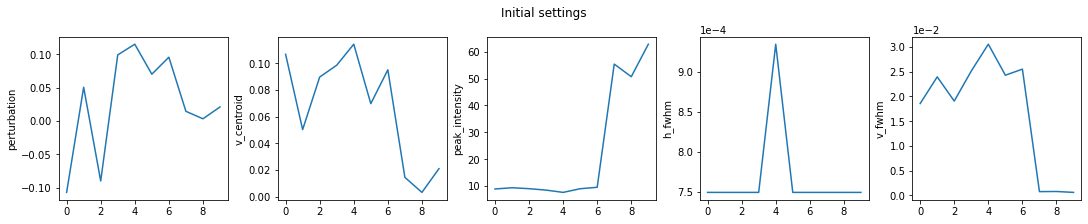

In [21]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

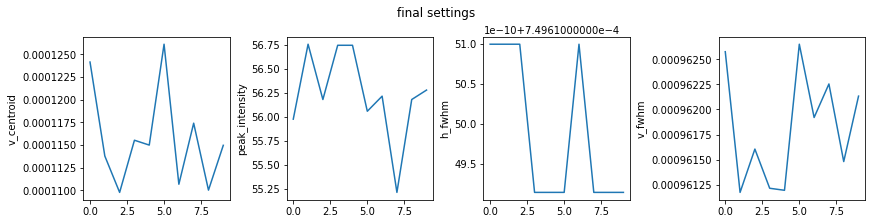

In [22]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

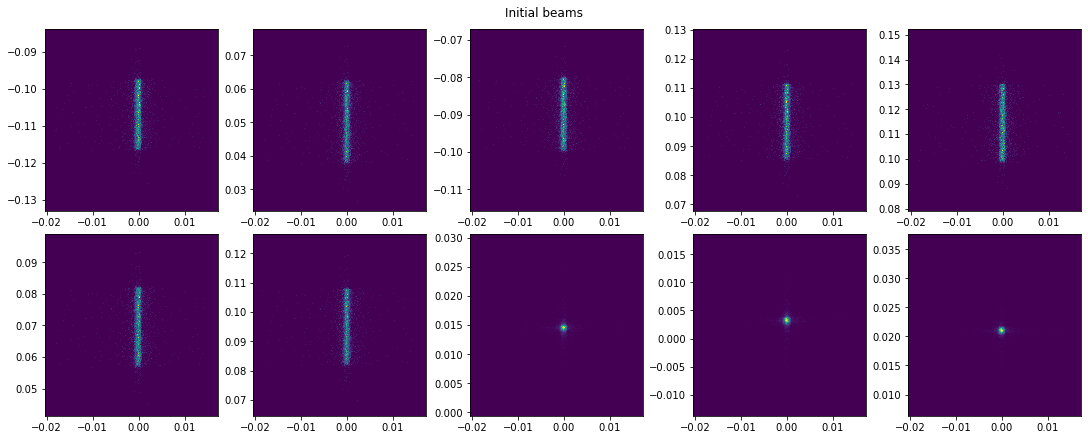

In [23]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

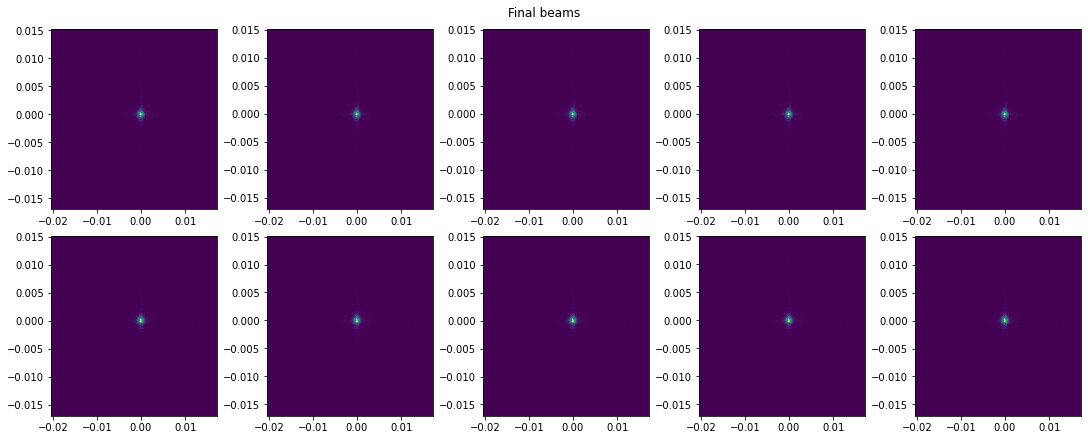

In [24]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

In [25]:
clean_up()

In [26]:
shutil.rmtree(temp_work_dir)